# Auto Compression

- [Tutorial](https://github.com/hyperopt/hyperopt/wiki/FMin)

In [1]:
from hyperopt import hp
from hyperopt import fmin, STATUS_OK, Trials
import hyperopt
import math
import numpy as np
import argparse
import time
import datetime
import os
import sys
import torch
import torch.nn as nn
import torch.optim
from torch.autograd import Variable
# script_dir = os.path.dirname(__file__)
# module_path = os.path.abspath(os.path.join(script_dir, '..', '..'))
# try:
#     import distiller
# except ImportError:
#     sys.path.append(module_path)
#     import distiller
import distiller
import apputils
from models import ALL_MODEL_NAMES, create_model
from copy import deepcopy
import json
import matplotlib.pyplot as plt 
import pandas as pd
plt.style.use('ggplot')

In [39]:
def float_range(val_str):
    val = float(val_str)
    if val < 0 or val >= 1:
        raise argparse.ArgumentTypeError('Must be >= 0 and < 1 (received {0})'.format(val_str))
    return val

def get_space(mode, low, high):
    space = {}
    for name, parameter in model.named_parameters():
        if name == 'module.pre_layers.0.weight':
            space[name] = hp.uniform(name, low, high)
        elif 'b1' in name and '.0.' in name and 'weight' in name:
            space[name] = hp.uniform(name, low, high)
        elif 'b2' in name and '.0.' in name and 'weight' in name:
            space[name] = hp.uniform(name, low, high)
        elif 'b2' in name and '.3.' in name and 'weight' in name:
            space[name] = hp.uniform(name, low, high)
        elif 'b3' in name and '.0.' in name and 'weight' in name:
            space[name] = hp.uniform(name, low, high)
        elif 'b3' in name and '.3.' in name and 'weight' in name:
            space[name] = hp.uniform(name, low, high)
        elif 'b3' in name and '.6.' in name and 'weight' in name:
            space[name] = hp.uniform(name, low, high)
        elif 'b4' in name and '.1.' in name and 'weight' in name:
            space[name] = hp.uniform(name, low, high)
    return space

## Argument Settings

In [25]:
parser = argparse.ArgumentParser(description='Distiller image classification model compression')
parser.add_argument('data', metavar='DIR', help='path to dataset')
parser.add_argument('--arch', '-a', metavar='ARCH', default='resnet20_cifar',
                    choices=ALL_MODEL_NAMES,
                    help='model architecture: ' +
                    ' | '.join(ALL_MODEL_NAMES) +
                    ' (default: resnet20_cifar)')
parser.add_argument('-r', '--rounds', default=10, type=int,
                    metavar='R', help='max rounds (default: 10)')
parser.add_argument('--epochs', default=120, type=int,
                    metavar='E', help='epochs (default: 120)')
parser.add_argument('-j', '--workers', default=1, type=int, metavar='N',
                    help='number of data loading workers (default: 1)')
parser.add_argument('-b', '--batch-size', default=128, type=int,
                    metavar='N', help='mini-batch size (default: 128)')
parser.add_argument('--gpus', metavar='DEV_ID', default=None,
                    help='Comma-separated list of GPU device IDs to be used (default is to use all available devices)')
parser.add_argument('--lr', '--learning-rate', default=0.01, type=float,
                    metavar='LR', help='initial learning rate')
parser.add_argument('--momentum', default=0.9, type=float, metavar='M',
                    help='momentum')
parser.add_argument('--weight-decay', '--wd', default=1e-4, type=float,
                    metavar='W', help='weight decay (default: 1e-4)')
parser.add_argument('--validation-size', '--vs', type=float_range, default=0.1,
                    help='Portion of training dataset to set aside for validation')
parser.add_argument('--deterministic', '--det', action='store_true',
                    help='Ensure deterministic execution for re-producible results.')
parser.add_argument('--resume', default='', type=str, metavar='PATH',
                    help='path to latest checkpoint (default: none)')

# [Manual setting hyperparameters]
# If execute in command line, use the following line instead:
#    args = parser.parse_args()  
args = parser.parse_args(args=[
    '/tmp/work/data/CINIC-10/',
    '-a', 'googlenet_cinic',
    '--gpus', '0',
    '--resume', '../../pytorch-cifar/checkpoint/googLeNet.cinic10.0.t7'
])

## Data Loading & Model Creation

In [41]:
# Infer the dataset from the model name
if 'cinic' in args.arch:
    args.dataset = 'cinic10'
else:
    args.dataset = 'cifar10' if 'cifar' in args.arch else 'imagenet'
args.num_classes = 10 if args.dataset in ['cifar10', 'cinic10'] else 1000

# Set Device
if args.gpus is not None:
    try:
        args.gpus = [int(s) for s in args.gpus.split(',')]
    except ValueError:
        exit(1)
    available_gpus = torch.cuda.device_count()
    for dev_id in args.gpus:
        if dev_id >= available_gpus:
            exit(1)
    # Set default device in case the first one on the list != 0
    torch.cuda.set_device(args.gpus[0])

In [5]:
# Create Model
model = create_model(False, args.dataset, args.arch, device_ids=args.gpus) # Get arch state_dict
train_loader, val_loader, test_loader, _ = apputils.load_data(
        args.dataset, os.path.expanduser(args.data), args.batch_size,
        args.workers, args.validation_size, args.deterministic)

In [26]:
# Load Pre-trained Model
chkpt_file=args.resume
print("=> loading checkpoint %s" % chkpt_file)
checkpoint = torch.load(chkpt_file)
model.load_state_dict(checkpoint['net'])

=> loading checkpoint ../../pytorch-cifar/checkpoint/googLeNet.cinic10.0.t7


## Functions

###  1. Train & Validate

In [27]:
def train(epoch, criterion, optimizer, compression_scheduler):
    correct = 0
    total = 0
    total_samples = len(train_loader.sampler)
    batch_size = train_loader.batch_size
    steps_per_epoch = math.ceil(total_samples / batch_size)
    for train_step, (inputs, targets) in enumerate(train_loader):
        compression_scheduler.on_minibatch_begin(epoch, train_step, steps_per_epoch, optimizer)
        inputs, targets = inputs.cuda(), targets.cuda()
        outputs = model(inputs.cuda())
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum().data.numpy()
        loss = criterion(outputs, targets)
        compression_scheduler.before_backward_pass(epoch, train_step, steps_per_epoch, loss,
                                                   optimizer=optimizer, return_loss_components=True)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        compression_scheduler.on_minibatch_end(epoch, train_step, steps_per_epoch, optimizer)
    accuracy = 100. * correct / total    
    return accuracy

In [28]:
def validate():
    model.eval() 
    correct = 0
    total = 0
    with torch.no_grad():
        for test_step, (inputs, targets) in enumerate(val_loader):
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += predicted.eq(targets.data).cpu().sum().data.numpy()
    accuracy = 100. * correct / total    
    return accuracy

### 2. Testing

In [29]:
def test():
    model.eval() 
    correct = 0
    total = 0
    with torch.no_grad():
        for test_step, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += predicted.eq(targets.data).cpu().sum().data.numpy()
    accuracy = 100. * correct / total    
    return accuracy

### 3. Objective Function

In [30]:
count = 0
def objective(space):
    global model
    global count
    #Explore new model
    model = create_model(False, args.dataset, args.arch, device_ids=args.gpus)
    count += 1
    # Objective function: F(Acc, Lat) = (1 - Acc.) + (alpha * Sparsity)
    accuracy = 0
    alpha = 0.2 # Super-parameter: the importance of inference time
    latency = 0.0
    sparsity = 0.0
    # Training hyperparameter
    criterion = nn.CrossEntropyLoss().cuda()
    optimizer = torch.optim.SGD(model.parameters(), lr=args.lr,
                                momentum=args.momentum,
                                weight_decay=args.weight_decay)
    """
    distiller/distiller/config.py
        # Element-wise sparsity
        sparsity_levels = {net_param: sparsity_level}
        pruner = distiller.pruning.SparsityLevelParameterPruner(name='sensitivity', levels=sparsity_levels)
        policy = distiller.PruningPolicy(pruner, pruner_args=None)
        scheduler = distiller.CompressionScheduler(model)
        scheduler.add_policy(policy, epochs=[0, 2, 4])
        # Local search 
        add multiple pruner for each layer
    """
    sparsity_levels = {}
    for key, value in space.items():
        sparsity_levels[key] = value
    pruner = distiller.pruning.SparsityLevelParameterPruner(name='sensitivity', levels=sparsity_levels)
    policy = distiller.PruningPolicy(pruner, pruner_args=None)
    lrpolicy = distiller.LRPolicy(torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1))
    compression_scheduler = distiller.CompressionScheduler(model)
    #compression_scheduler.add_policy(policy, epochs=[90])    
    compression_scheduler.add_policy(policy, starting_epoch=0, ending_epoch=90, frequency=1)
    compression_scheduler.add_policy(lrpolicy, starting_epoch=0, ending_epoch=90, frequency=1)
    """
    distiller/example/classifier_compression/compress_classifier.py
    For each epoch:
        compression_scheduler.on_epoch_begin(epoch)
        train()
        save_checkpoint()
        compression_scheduler.on_epoch_end(epoch)

    train():
        For each training step:
            compression_scheduler.on_minibatch_begin(epoch)
            output = model(input)
            loss = criterion(output, target)
            compression_scheduler.before_backward_pass(epoch)
            loss.backward()
            optimizer.step()
            compression_scheduler.on_minibatch_end(epoch)
    """
    for i in range(args.epochs):
        compression_scheduler.on_epoch_begin(i)
        train_accuracy = train(i,criterion, optimizer, compression_scheduler)
        val_accuracy = validate() # Validate hyperparameter setting
        t, sparsity = distiller.weights_sparsity_tbl_summary(model, return_total_sparsity=True)
        compression_scheduler.on_epoch_end(i, optimizer)
        apputils.save_checkpoint(i, args.arch, model, optimizer, compression_scheduler, train_accuracy, False,
                                         'hyperopt', './')
    test_accuracy = test() # Validate hyperparameter setting
    score = (1-(val_accuracy/100.)) + (alpha * (1-sparsity/100.)) # objective funtion here
    print('{} trials: score: {:.4f}\ttrain acc:{:.4f}\tval acc:{:.4f}\ttest acc:{:.4f}\tsparsity:{:.4f}'.format(count, 
                                      score, 
                                      train_accuracy, 
                                      val_accuracy, 
                                      test_accuracy,
                                      sparsity))
    return {
        'loss': score, 
        'status': STATUS_OK,
        # -- store other results like this
        'train acc': train_accuracy,
        'val acc': val_accuracy,
        'test acc': test_accuracy,
        'sparsity': sparsity
        }

In [31]:
def save_logs(logs, filename):
    for log in logs:
        log['book_time'] = log['book_time'].timestamp()
        log['refresh_time'] = log['refresh_time'].timestamp()
        
    with open(filename, 'w') as fp:
        json.dump(logs, fp)

### 4. Plotting Functions

In [32]:
def plot_pareto_curve(data):
    data.sort(reverse=True)
    tops = []
    max_acc = 0
    for point in data:
        if(point[1] > max_acc):
            max_acc = point[1]
            tops.append(point)
            
    for i, top in enumerate(tops):
        if i == 0: continue;
        plt.plot([tops[i-1][0], tops[i][0]], [tops[i-1][1], tops[i][1]])
        
    for point in data:
        plt.scatter(point[0], point[1])
        
    plt.xlabel("sparsity (%)")
    plt.ylabel("accuracy (%)")

In [33]:
def drawTrainingProcess(logs):
    data = []
    for i,x in enumerate(logs):
        rec = x['result']
        data.append([i+1, rec['loss'], rec['train acc'], rec['val acc'], rec['sparsity']])
    df = pd.DataFrame(data, columns=['trial', 'score', 'train acc', 'val acc', 'sparsity'])
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
    
#     ax = plt.subplot(1, 3, 1)
#     ax.set_title('score')
#     ax.set_xlabel('trial')
#     ax.plot(df['trial'], df['score'])

    ax = plt.subplot(1, 2, 1)
    ax.set_title('sparsity')
    ax.set_xlabel('trial')
    ax.plot(df['trial'], df['sparsity'])

    ax = plt.subplot(1, 2, 2)
    ax.set_title('Accuracy')
    ax.set_xlabel('trial')
    ax.plot(df['trial'], df['train acc'])
    ax.plot(df['trial'], df['val acc'])
    ax.legend(['train', 'val'])
    ax.set_ylim((70, 100))

In [34]:
def drawBestHyperParams(logs):
    scores = [logs[i]['result']['loss'] for i in range(len(logs))]
    best_trial = scores.index(min(scores))
    best_weights = logs[best_trial]['misc']['vals']
    
    plt.figure(num=None, figsize=(20, 5))
    plt.bar(range(len(best_weights)), list([x[0] for x in best_weights.values()]), align='center')
    plt.xticks(range(len(best_weights)), list(best_weights.keys()), rotation=90)
    plt.show()

## Algorithm: TPE

In [35]:
trials = {}
best = {}

### 1. No Constraint

In [40]:
constraint = 'tpe_no_constraint'
space = get_space(model, 0.01, 0.99)
trials[constraint] = Trials()
best[constraint] = fmin(objective, space, algo=hyperopt.tpe.suggest, max_evals=args.rounds, trials=trials[constraint])

AttributeError: 'Namespace' object has no attribute 'dataset'

Save logs...

In [13]:
logs = deepcopy(trials[constraint].trials)
filename = 'tpe_no_constraint.json'
save_logs(logs, filename)

Load logs...

In [63]:
filename = 'tpe_no_constraint.json'
with open(filename, 'r') as f:
    logs = json.load(f)

Plot the results:

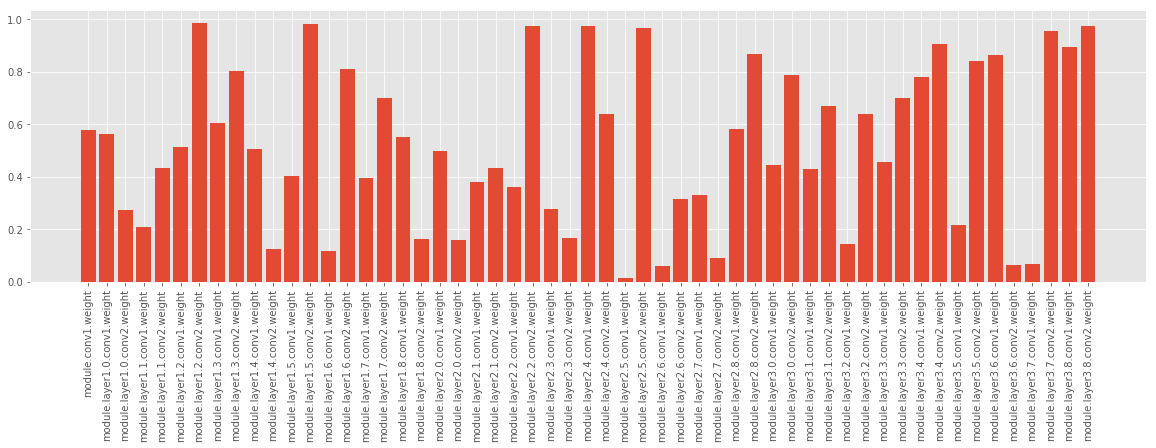

In [46]:
drawBestHyperParams(logs)

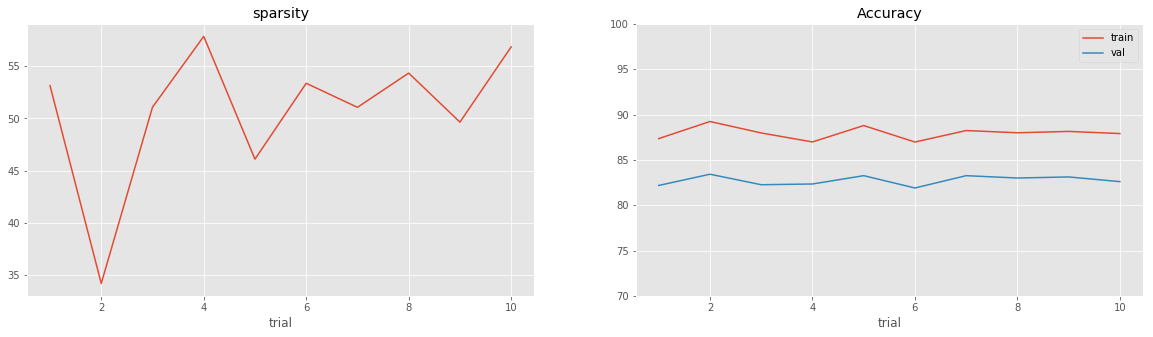

In [64]:
drawTrainingProcess(logs)

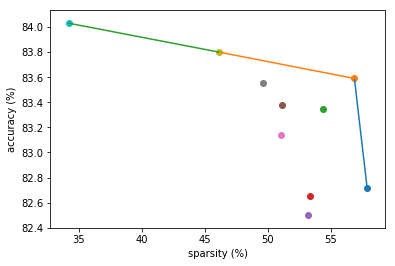

In [28]:
constraint = 'tpe_no_constraint'
data = [(trial['result']['sparsity'], trial['result']['test acc']) for trial in trials[constraint].trials]
plot_pareto_curve(data)

### 2. 70±2.5% sparsity

In [15]:
constraint = 'tpe_70_tol_2_5_sparsity'
space = get_space(0.675, 0.725)
trials[constraint] = Trials()
best[constraint] = fmin(objective, space, algo=hyperopt.tpe.suggest, max_evals=args.rounds, trials=trials[constraint])

11 trials: score: 0.2558	train acc:84.5333	val acc:80.4600	test acc:80.7700	sparsity:69.8098
12 trials: score: 0.2472	train acc:85.6733	val acc:81.3000	test acc:81.5300	sparsity:69.8792
13 trials: score: 0.2515	train acc:85.5756	val acc:80.8400	test acc:82.0000	sparsity:70.0384
14 trials: score: 0.2581	train acc:84.7756	val acc:80.2400	test acc:81.0600	sparsity:69.7481
15 trials: score: 0.2566	train acc:85.1356	val acc:80.3600	test acc:81.3000	sparsity:69.9173
16 trials: score: 0.2513	train acc:85.4311	val acc:80.8200	test acc:81.4200	sparsity:70.2321
17 trials: score: 0.2438	train acc:86.0111	val acc:81.7200	test acc:82.7100	sparsity:69.5125
18 trials: score: 0.2504	train acc:85.8400	val acc:81.1000	test acc:81.4900	sparsity:69.3069
19 trials: score: 0.2487	train acc:85.5400	val acc:81.1800	test acc:82.0100	sparsity:69.7383
20 trials: score: 0.2476	train acc:85.4356	val acc:81.3600	test acc:81.7500	sparsity:69.4167


Save logs...

In [16]:
logs = deepcopy(trials[constraint].trials)
filename = 'tpe_70_tol_2_5_sparsity.json'
save_logs(logs, filename)

Load logs...

In [65]:
filename = 'tpe_70_tol_2_5_sparsity.json'
with open(filename, 'r') as f:
    logs = json.load(f)

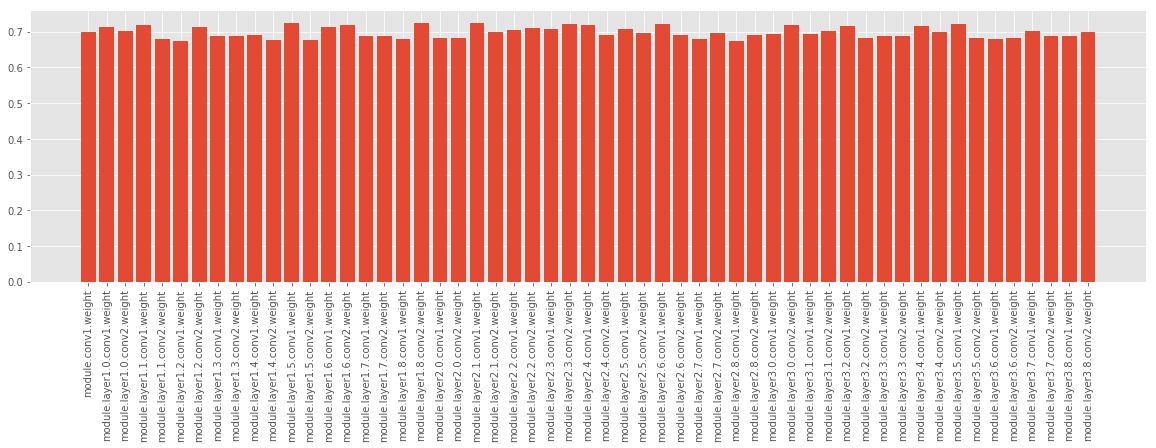

In [49]:
drawBestHyperParams(logs)

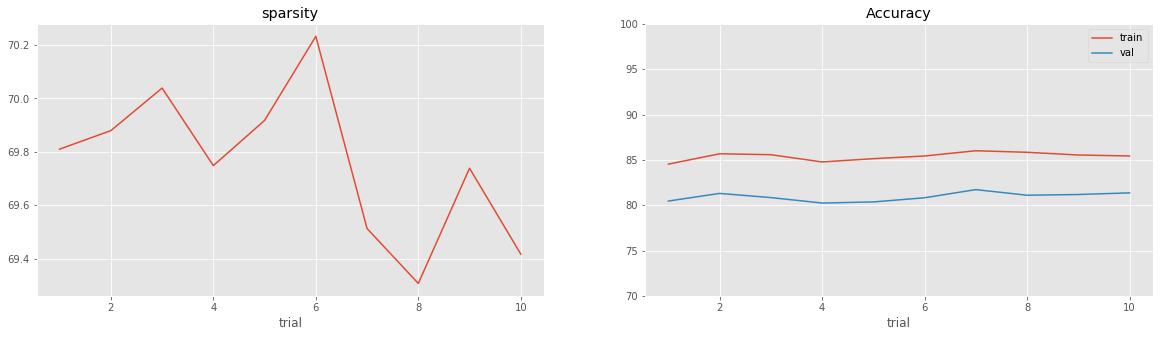

In [66]:
drawTrainingProcess(logs)

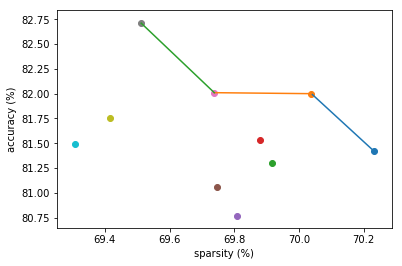

In [29]:
constraint = 'tpe_70_tol_2_5_sparsity'
data = [(trial['result']['sparsity'], trial['result']['test acc']) for trial in trials[constraint].trials]
plot_pareto_curve(data)

## Algorithm: Random Search

### 1. No Constraint

In [18]:
constraint = 'rand_no_constraint'
space = get_space(0.01, 0.99)
trials[constraint] = Trials()
best[constraint] = fmin(objective, space, algo=hyperopt.rand.suggest, max_evals=args.rounds, trials=trials[constraint])

21 trials: score: 0.2637	train acc:87.4200	val acc:82.7000	test acc:83.0900	sparsity:54.6446
22 trials: score: 0.2944	train acc:87.9711	val acc:81.8600	test acc:83.1900	sparsity:43.5134
23 trials: score: 0.2570	train acc:88.4867	val acc:83.8400	test acc:83.8300	sparsity:52.3171
24 trials: score: 0.2879	train acc:87.9889	val acc:82.8000	test acc:82.7800	sparsity:42.0309
25 trials: score: 0.2643	train acc:88.0333	val acc:83.1200	test acc:83.9800	sparsity:52.2566
26 trials: score: 0.2803	train acc:87.5556	val acc:82.2400	test acc:82.9000	sparsity:48.6466
27 trials: score: 0.2763	train acc:87.6622	val acc:82.7000	test acc:83.2000	sparsity:48.3745
28 trials: score: 0.2759	train acc:85.8689	val acc:80.6000	test acc:82.1000	sparsity:59.0374
29 trials: score: 0.2762	train acc:88.1200	val acc:82.9400	test acc:83.2900	sparsity:47.1901
30 trials: score: 0.2837	train acc:89.5578	val acc:83.4200	test acc:84.4400	sparsity:41.0456


Save logs...

In [19]:
logs = deepcopy(trials[constraint].trials)
filename = 'rand_no_constraint.json'
save_logs(logs, filename)

Load logs...

In [67]:
filename = 'rand_no_constraint.json'
with open(filename, 'r') as f:
    logs = json.load(f)

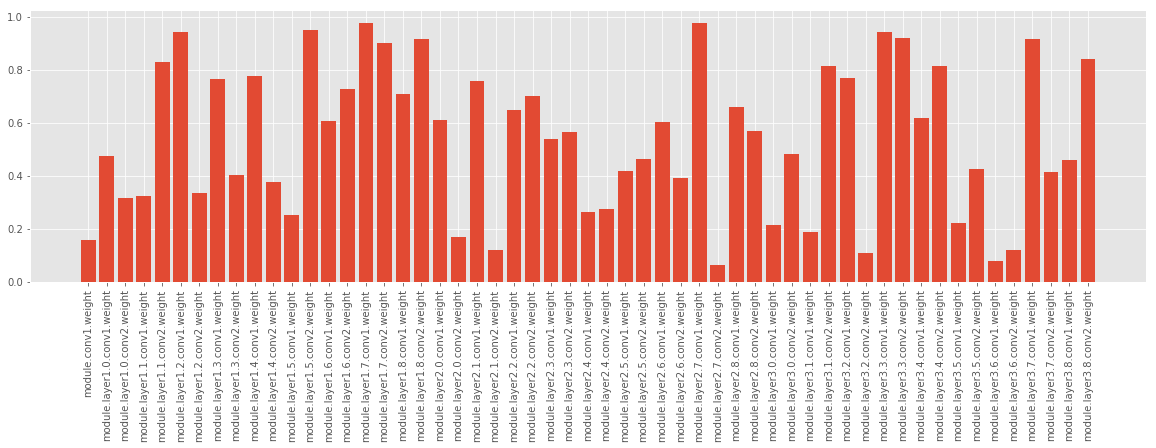

In [52]:
drawBestHyperParams(logs)

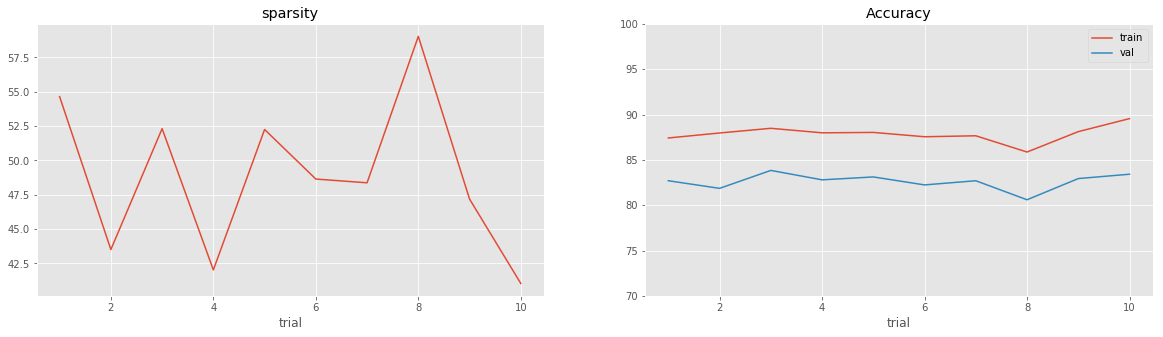

In [68]:
drawTrainingProcess(logs)

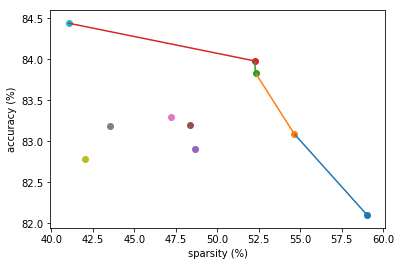

In [30]:
constraint = 'rand_no_constraint'
data = [(trial['result']['sparsity'], trial['result']['test acc']) for trial in trials[constraint].trials]
plot_pareto_curve(data)

### 2. 70±2.5% sparsity

In [21]:
constraint = 'rand_70_tol_2_5_sparsity'
space = get_space(0.675, 0.725)
trials[constraint] = Trials()
best[constraint] = fmin(objective, space, algo=hyperopt.rand.suggest, max_evals=args.rounds, trials=trials[constraint])

31 trials: score: 0.2494	train acc:85.1333	val acc:81.1600	test acc:82.1200	sparsity:69.5055
32 trials: score: 0.2430	train acc:86.4333	val acc:81.8400	test acc:82.1200	sparsity:69.2984
33 trials: score: 0.2450	train acc:85.6644	val acc:81.5600	test acc:81.8500	sparsity:69.7035
34 trials: score: 0.2562	train acc:84.8422	val acc:80.4000	test acc:81.4500	sparsity:69.8950
35 trials: score: 0.2451	train acc:85.0289	val acc:81.5400	test acc:80.9200	sparsity:69.7664
36 trials: score: 0.2437	train acc:85.8067	val acc:81.7200	test acc:81.9900	sparsity:69.5715
37 trials: score: 0.2567	train acc:85.6444	val acc:80.4000	test acc:82.0100	sparsity:69.6296
38 trials: score: 0.2400	train acc:85.7133	val acc:82.1200	test acc:81.9000	sparsity:69.3806
39 trials: score: 0.2442	train acc:85.8822	val acc:81.5800	test acc:82.1800	sparsity:69.9943
40 trials: score: 0.2492	train acc:85.8022	val acc:81.1000	test acc:81.7500	sparsity:69.9076


Save logs...

In [22]:
logs = deepcopy(trials[constraint].trials)
filename = 'rand_70_tol_2_5_sparsity.json'
save_logs(logs, filename)

Load logs...

In [69]:
filename = 'rand_70_tol_2_5_sparsity.json'
with open(filename, 'r') as f:
    logs = json.load(f)

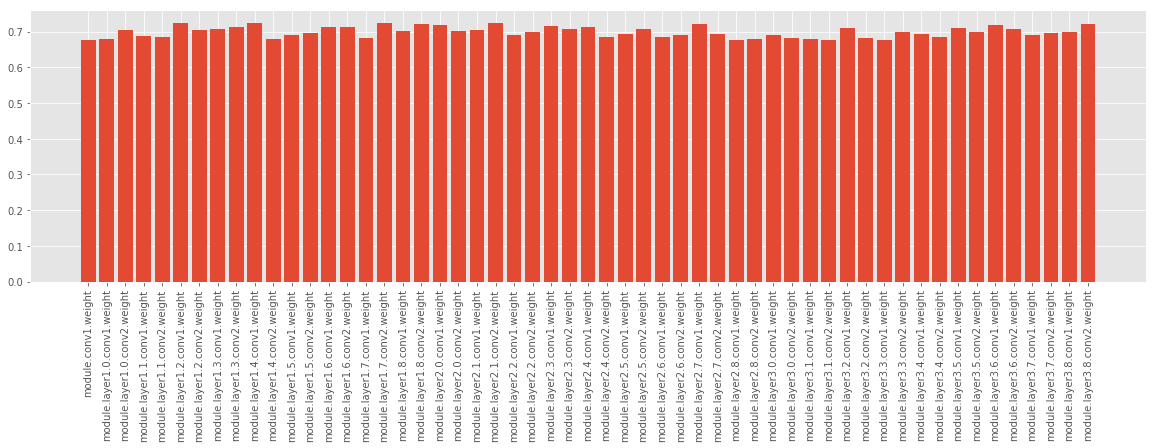

In [55]:
drawBestHyperParams(logs)

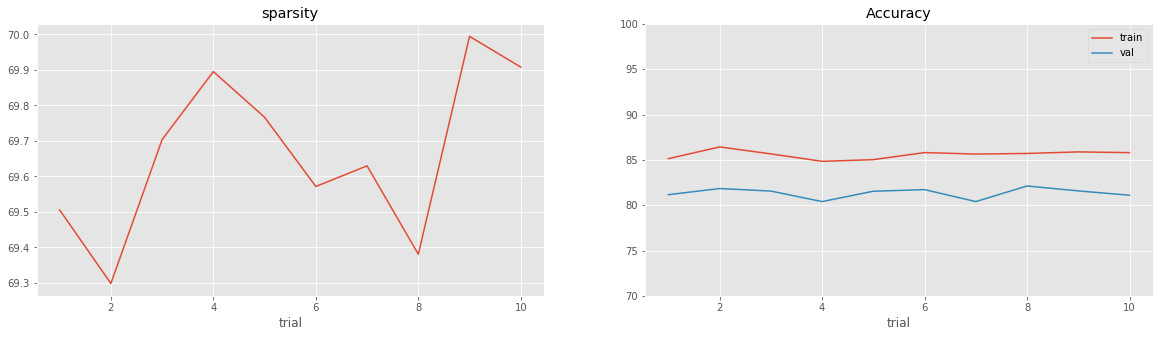

In [70]:
drawTrainingProcess(logs)

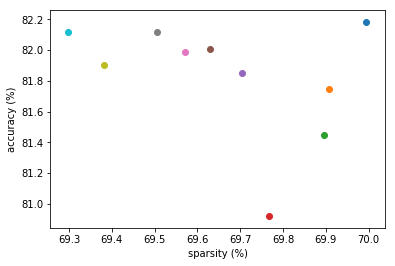

In [37]:
constraint = 'rand_70_tol_2_5_sparsity'
data = [(trial['result']['sparsity'], trial['result']['test acc']) for trial in trials[constraint].trials]
plot_pareto_curve(data)